# DCT, Walsh, Haar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.linalg as l
from IPython.display import display, Math, Latex
from PIL import Image, ImageFilter
import os, os.path
import glob
from copy import deepcopy, copy
import time
from math import trunc, log, sqrt

# Introduction
We will be implementing 3 transform in this experiment. The Discrete Cosine transform, the Walsh Transform, and the Haar transform and visualize how this 3 transform store there coefficients.

# Method
Once we implement all 3 transform we will test it on different images and see how the graph of the frequency domain looks like and then we will compare how this three transform retrieves their signal and where it is store.

In [2]:
display(Math(r'F(u,v) = 1/MN \sum_{i=0}^{M-1} \sum_{i=0}^{N-1} f(m,n)e^{-j2pi(um/M + vn/N)}'))

<IPython.core.display.Math object>

In [3]:
# Image resizing
def average_channel(channel):
    ret = []
    #print(channel.shape)
    for i in range(0,channel.shape[0],2):
        img_row = []
        for j in range(0,channel.shape[1],2):
            #print(channel[i][j])
            #print(channel[i+1][j])
            #print(channel[i][j+1])
            #print(channel[i+1][j+1])
            avg = int(channel[i][j]) + int(channel[i+1][j]) + int(channel[i][j+1]) + int(channel[i+1][j+1])
            #print(avg)
            avg = avg/4
            img_row.append(np.uint8(avg))
        #print(img_row)
        ret.append(img_row)
    
    return np.array(ret)

def reduce_image(image):
    if(len(image.shape) < 3):
        image = image.reshape(image.shape[0],image.shape[1],1)
    if(image.dtype == 'float32'):
        image = image*255
    
    width = image.shape[0]
    height = image.shape[1]
    channels = image.shape[2]
    #print(image.shape[0])
    if((width%2) == 1):
        image = image[:-1,:,:]
        #print(image.shape[0])
        width-=1
        
    if((height%2) == 1):
        image = image[:,:-1,:]
        #print(image.shape[0])
        height-=1
        
    #plt.imshow(image,cmap='gray')
    #plt.show()
    if(channels > 1):
        red = np.reshape(image[...,0],(width,height))
        green = np.reshape(image[...,1],(width,height))
        blue = np.reshape(image[...,2],(width,height))
    elif(channels==1):
        red = np.reshape(image[...,0],(width,height))
        green = np.reshape(image[...,0],(width,height))
        blue = np.reshape(image[...,0],(width,height))
    else:
        raise Exception("Invalid image channels")
        
    average_red = average_channel(red)
    average_green = average_channel(green)
    average_blue = average_channel(blue)
    #ret = np.append(np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    #ret = np.append(ret,np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    ret = np.append(np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),np.reshape(average_green,(average_green.shape[0],average_green.shape[1],1)),axis=-1)
    ret = np.append(ret,np.reshape(average_blue,(average_blue.shape[0],average_blue.shape[1],1)),axis=-1)
    return ret
    
    

In [4]:
def display_DFT(computed_DFT):
    return np.sqrt(np.square(computed_DFT[0])  +  np.square(computed_DFT[1]))
def scale_display(disp):
    maximum = np.max(disp)
    return ((255/np.log10(255))*np.log10(1+(255/maximum)*disp)).astype('int32')

In [5]:
def delt(inp):
    if(inp == 0):
        return 1/np.sqrt(2)
    return 1

def DCT_channel(image):
    ret = np.zeros((image.shape[0],image.shape[1],1))
    for v in range(image.shape[1]):
        #print('v = \n',v)
        for u in range(image.shape[0]):
            
            
            #print('u = \n',u)
            real = 0

            for y in range(image.shape[1]):
                for x in range(image.shape[0]):
                    factor = (delt(y)/(np.sqrt(2/image.shape[1])))*(delt(x)/(np.sqrt(2/image.shape[0])))
                    f = image[x][y]
                    x_factor = math.cos(((2*x)+1)*u*math.pi/(2*image.shape[0]))
                    y_factor = math.cos(((2*y)+1)*v*math.pi/(2*image.shape[1]))
                    real  = real + (f*x_factor*y_factor*factor)
            ret[u][v][0] = real
    return (ret)

def DFT_centered(image):
    ret = np.zeros((image.shape[0],image.shape[1],2))
    for v in range(image.shape[1]):
        #print('v = \n',v)
        for u in range(image.shape[0]):
            #print('u = \n',u)
            real = 0
            imag = 0
            for y in range(image.shape[1]):
                for x in range(image.shape[0]):
                    f = image[x][y]*((-1)**(x+y))
                    inner = ((u*x)/image.shape[0]) + ((v*y)/image.shape[1])
                    inner = inner *  (-2*math.pi )
                    real_part = math.cos(inner)
                    imaginary_part = math.sin(inner)
                    real = real + f*real_part
                    imag = imag + f*imaginary_part
            ret[u][v][0] = real
            ret[u][v][1] = imag
    return (ret/image.shape[1])/image.shape[0]

In [6]:
def DCT(image,centered = False):
    if(len(image.shape) < 3):
        image = image.reshape(image.shape[0],image.shape[1],1)
    if(image.dtype == 'float32'):
        image = image*255
    
    width = image.shape[0]
    height = image.shape[1]
    channels = image.shape[2]

    if(channels > 1):
        red = np.reshape(image[...,0]/255,(width,height))
        green = np.reshape(image[...,1]/255,(width,height))
        blue = np.reshape(image[...,2]/255,(width,height))
    elif(channels==1):
        red = np.reshape(image[...,0],(width,height))
        green = np.reshape(image[...,0],(width,height))
        blue = np.reshape(image[...,0],(width,height))
    else:
        raise Exception("Invalid image channels")
    
    if(not centered):
        Transformed_red = DCT_channel(red)
        Transformed_green = DCT_channel(green)
        Transformed_blue = DCT_channel(blue)
        #print(Transformed_red.shape)
    else:
        Transformed_red = DCT_channel(red)
        Transformed_green = DCT_channel(green)
        Transformed_blue = DCT_channel(blue)
        #print(Transformed_red.shape)  
    
    Real_red = Transformed_red[...,0]
    Real_green = Transformed_green[...,0]
    Real_blue = Transformed_blue[...,0]
    
    #ret = np.append(np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    #ret = np.append(ret,np.reshape(average_red,(average_red.shape[0],average_red.shape[1],1)),axis=-1)
    ret_real = np.append(np.reshape(Real_red,(Real_red.shape[0],Real_red.shape[1],1)),np.reshape(Real_green,(Real_green.shape[0],Real_green.shape[1],1)),axis=-1)
    ret_real = np.append(ret_real,np.reshape(Real_blue,(Real_blue.shape[0],Real_blue.shape[1],1)),axis=-1)
    
    #ret_imag = np.append(np.reshape(Imag_red,(Imag_red.shape[0],Imag_red.shape[1],1)),np.reshape(Imag_green,(Imag_green.shape[0],Imag_green.shape[1],1)),axis=-1)
    #ret_imag = np.append(ret_imag,np.reshape(Imag_blue,(Imag_blue.shape[0],Imag_blue.shape[1],1)),axis=-1)
  
    return ret_real

In [7]:
ima = []
for filename in glob.glob('imagesHW2/32x32/*.jpg'): #assuming gif
    img = plt.imread(filename)
    ima.append(img)

In [8]:
tansformed_img = DCT(ima[0])

C:\Users\Thony\Anaconda3\envs\DEEP\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


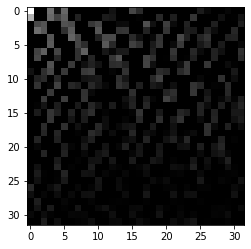

In [9]:
#display = display_DFT(tansformed_img)
display = scale_display(tansformed_img)

plt.imshow(display,cmap='gray')

In [10]:
def show(o_img, dct):    
    fig = plt.figure()
    fig.set_figheight(25)
    fig.set_figwidth(25)

    fig.add_subplot(1,2,1)
    plt.imshow(o_img, cmap='gray')

    # display the new image
    fig.add_subplot(1,2,2)
    plt.imshow(dct, cmap='gray')

    

    plt.show(block=True)

C:\Users\Thony\Anaconda3\envs\DEEP\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


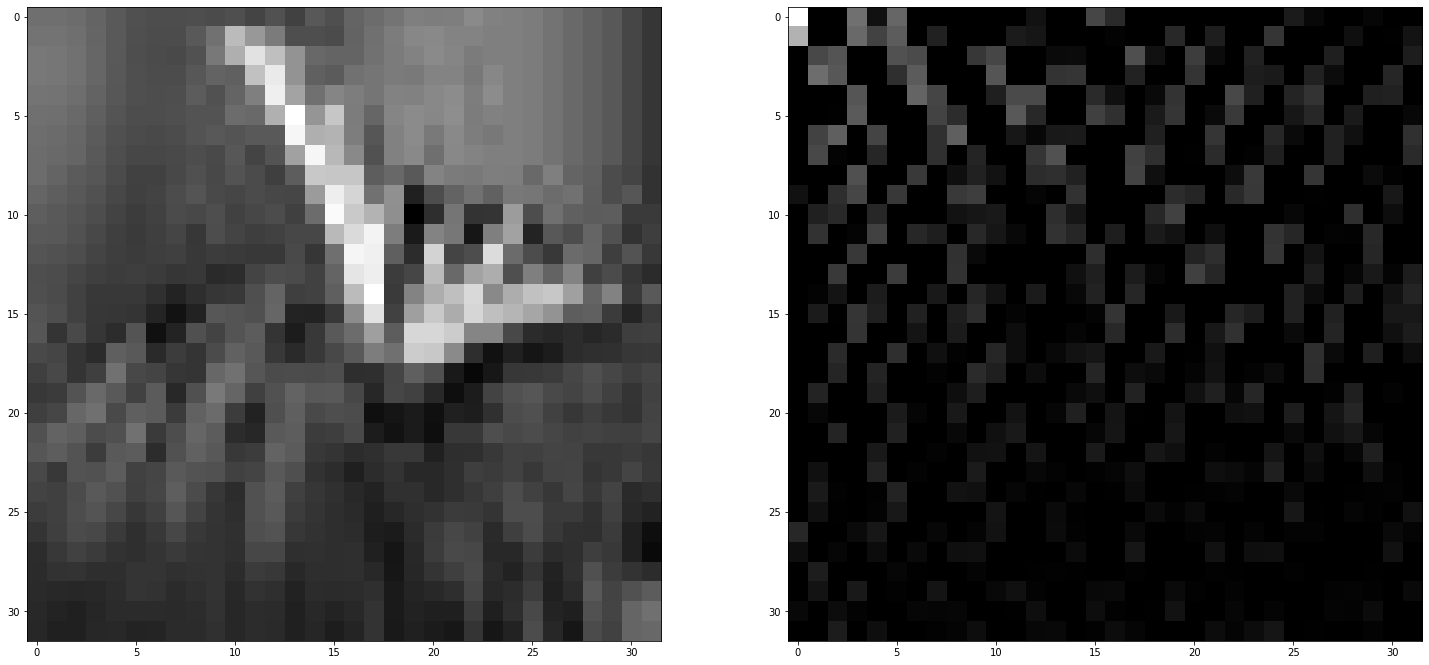

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


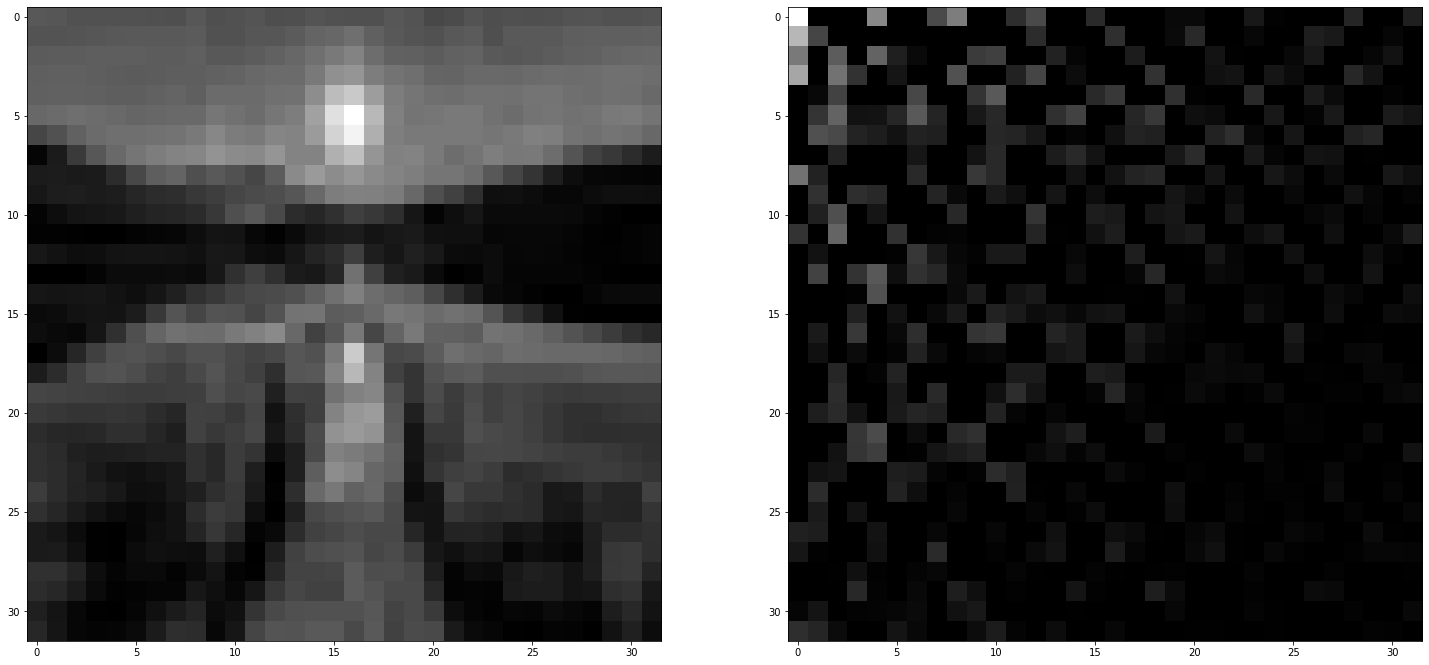

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


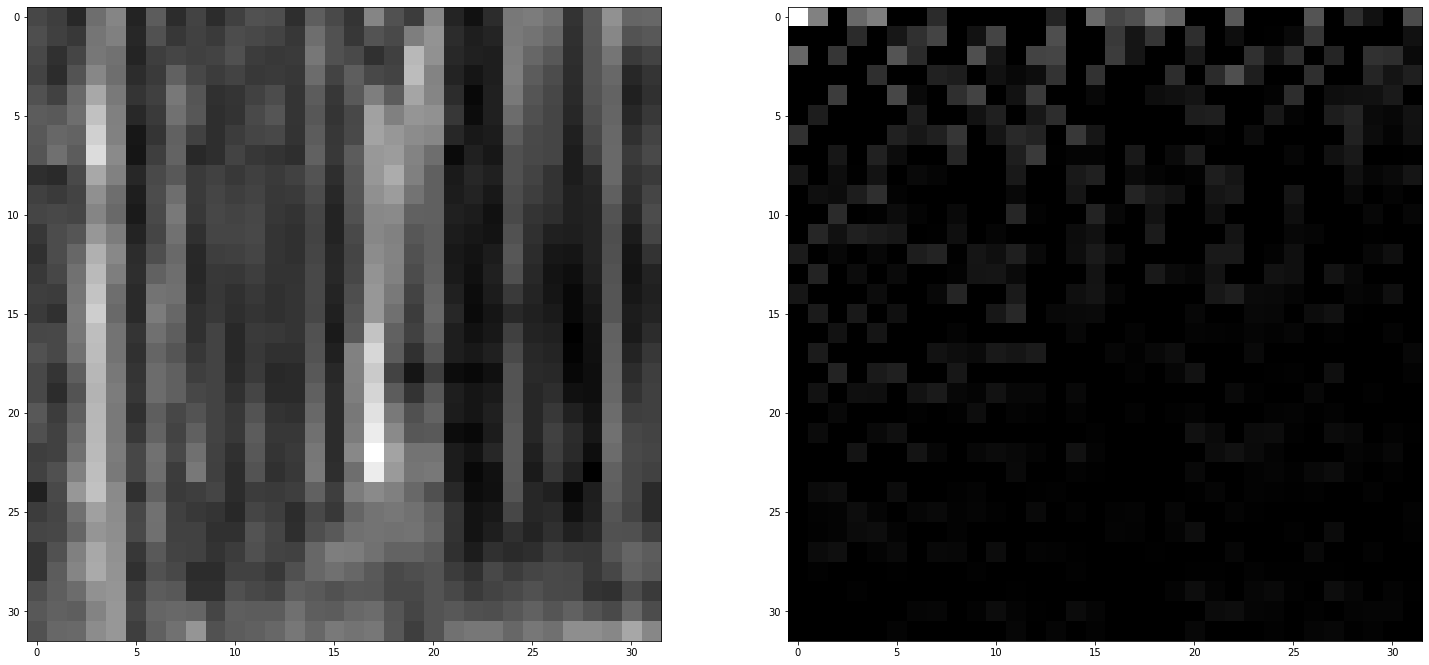

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


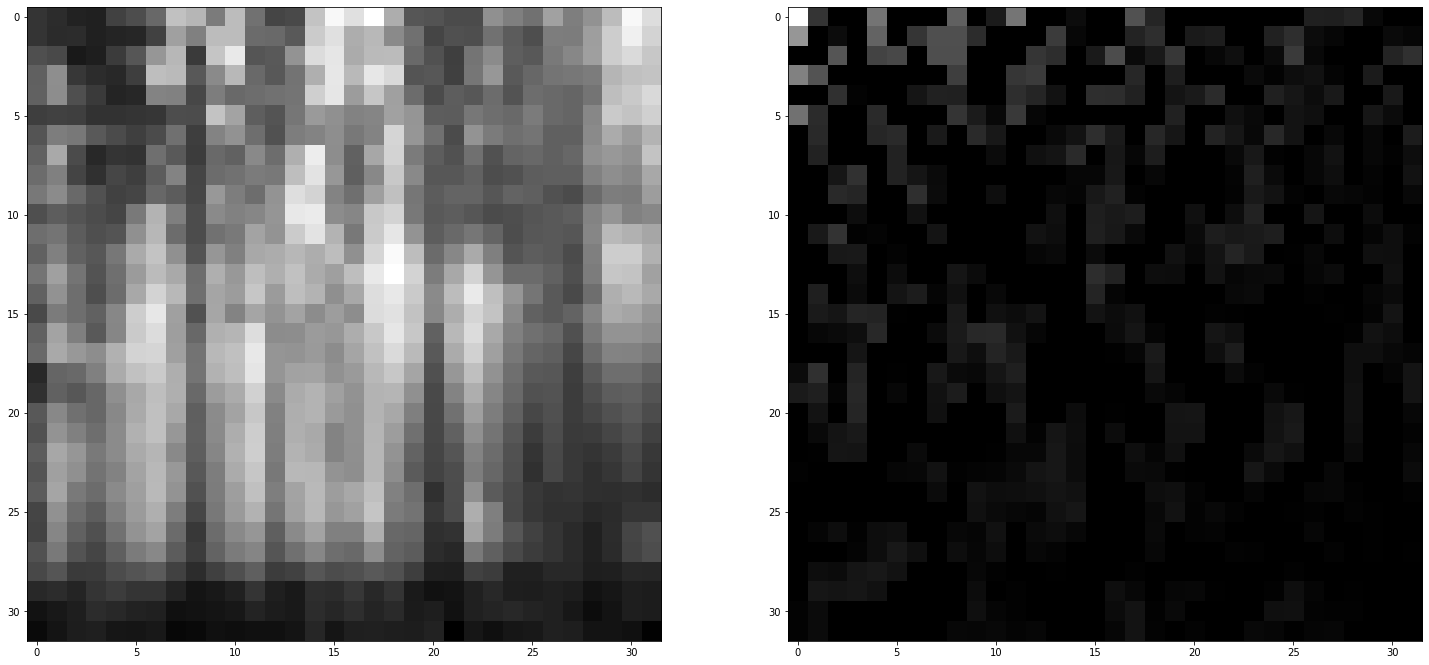

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


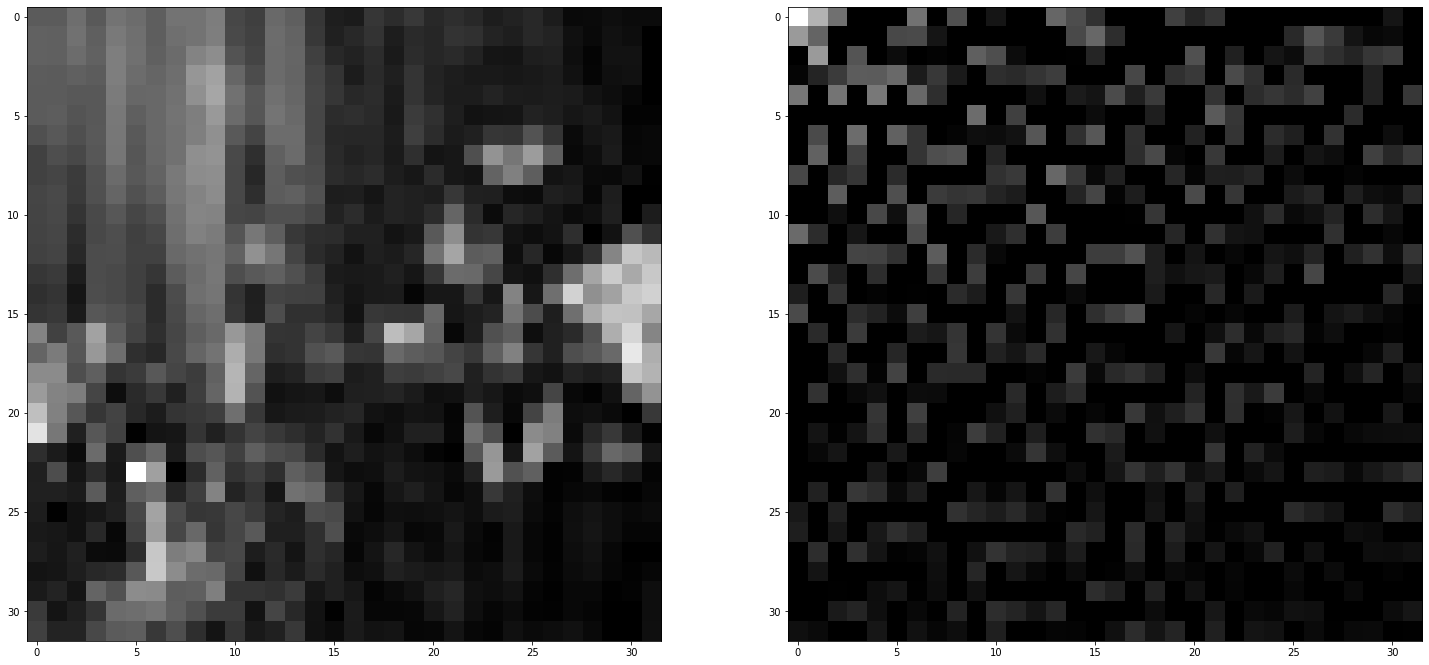

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


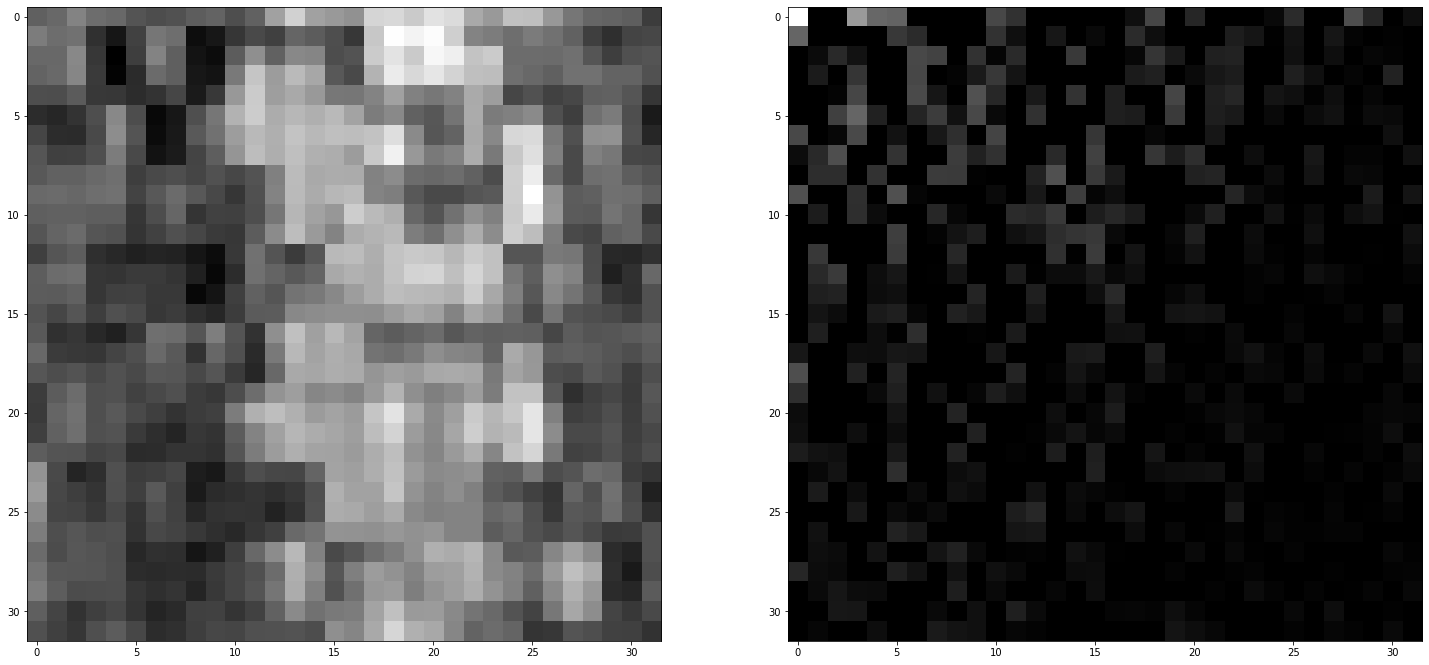

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


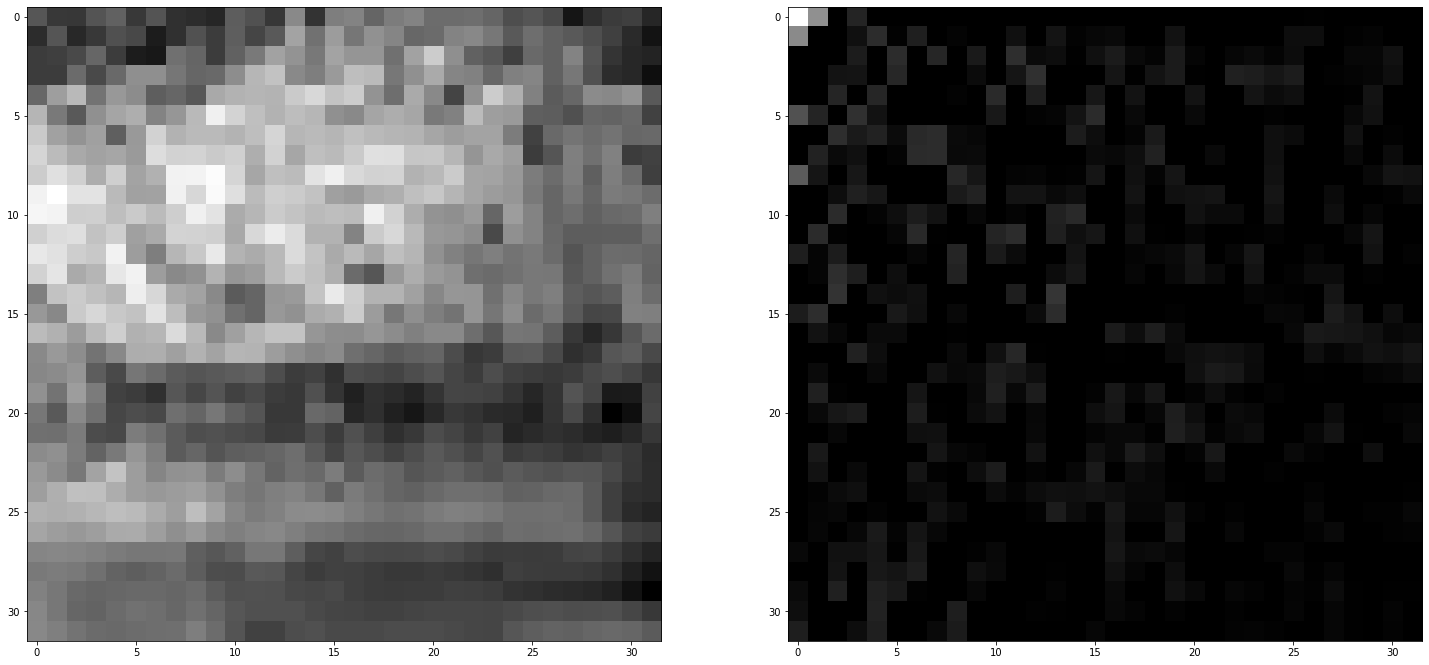

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


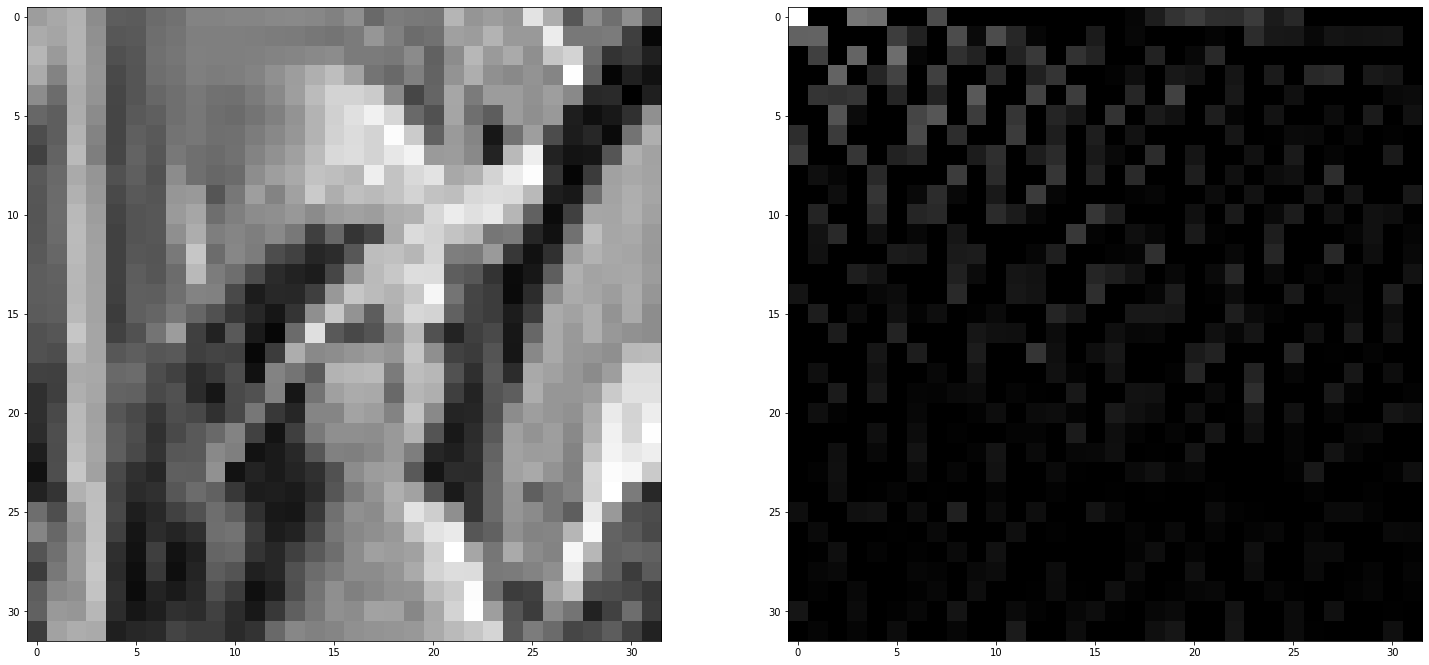

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


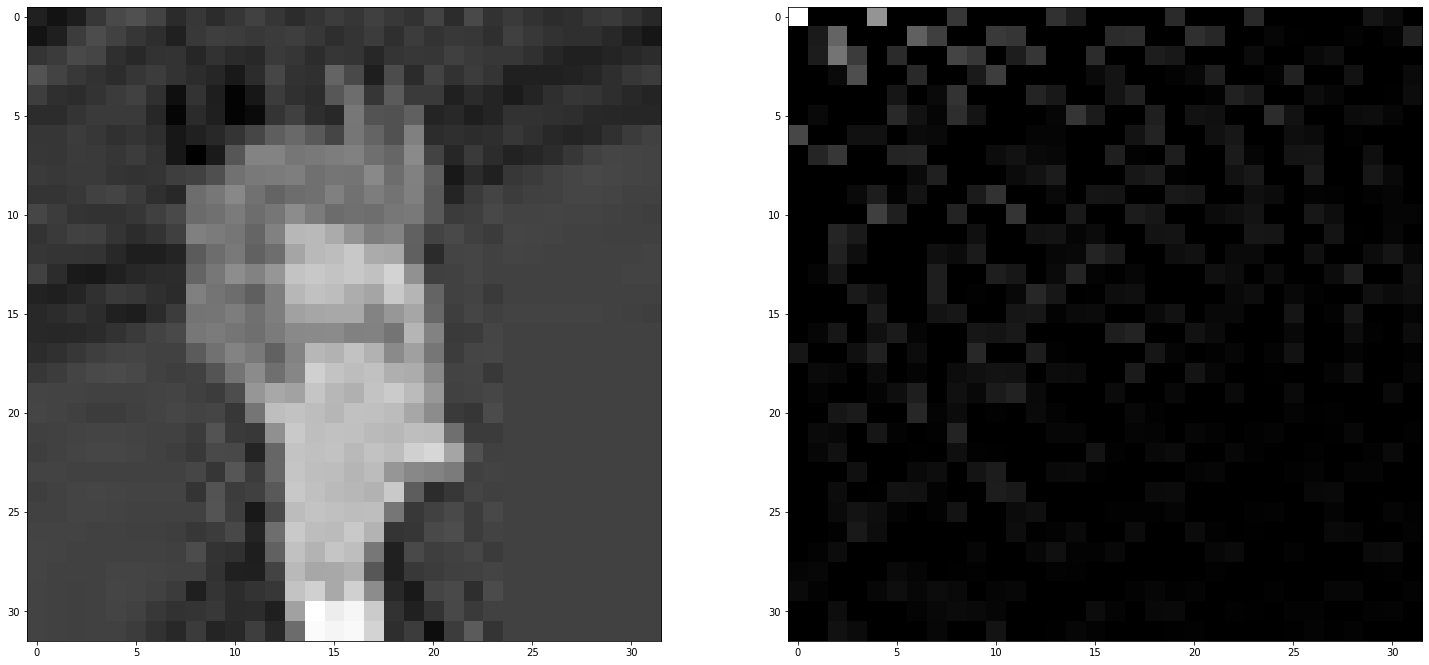

In [11]:
trans = []
for i in range(len(ima)):
    tansformed_img = DCT(ima[i])
    display = scale_display(tansformed_img)
    trans.append(display)
    show(ima[i], display)

In [12]:
def show(o_img, walsh, inv_img):    
    fig = plt.figure()
    fig.set_figheight(25)
    fig.set_figwidth(25)

    fig.add_subplot(1,3,1)
    plt.imshow(o_img, cmap='gray')

    # display the new image
    fig.add_subplot(1,3,2)
    plt.imshow(walsh, cmap='gray')

    fig.add_subplot(1,3,3)
    plt.imshow(inv_img, cmap='gray')

    plt.show(block=True)

In [13]:
ima = []
for filename in glob.glob('imagesHW2/32x32/*.jpg'): #assuming gif
    im = Image.open(filename)
    im = im.convert('L')
    ima.append(im)

In [14]:
def m_range(m,r,n):
    s = (m-0.5)/(2**r)
    s = s * n
    return int(s)

In [15]:
def e_range(m,r,n):
    s = (m)/((2)**r)
    s = s * n
    return int(s)

In [16]:
def s_range(m,r,n):
    s = (m-1)/(2**r)
    s = s * n
    return int(s)

In [17]:
def create_kernel(N):
    
    ri = int(log(N,2))
    #print(ri)
    kernel = np.zeros((N,N))
    kernel[0] = 1
    #kernel[1] = 0.5
    #print(N)
    i = 0
    for r in range(ri):
        #print(r)
        for m in range(1,(2**r)+1):
            #print(m)
            s = s_range(m,r,N)
            mi = m_range(m,r,N)
            e = e_range(m,r,N)
            #print(s,mi,e)
            i = i+1
            for j in range(N):
                if s <= j < mi:
                    kernel[i][j] = (2)**(r/2)
                elif mi <= j < e:
                    kernel[i][j] = -(2)**(r/2)
                else:
                    kernel[i][j] = 0

    kernel = kernel / (sqrt(N))
    return kernel

In [18]:
def HaarTrans(img):
    img = np.asarray(img)
    N = img.shape[0]
    kernel = create_kernel(N)
    arr = np.asarray(img)
    trans = np.matmul(kernel, img)
    trans = np.matmul(trans, kernel)
    trans = np.around(trans)
    #plt.imshow(trans, cmap="gray")
    return trans

In [19]:
def InvHaarTrans(trans):
    N = trans.shape[0]
    kernel = create_kernel(N)
    inv = np.linalg.inv(kernel)
    inv_trans = np.matmul(inv, trans)
    inv_trans = np.matmul(inv_trans, inv)
    inv_trans = np.around(inv_trans)
    #plt.imshow(inv_trans, cmap="gray")
    return inv_trans

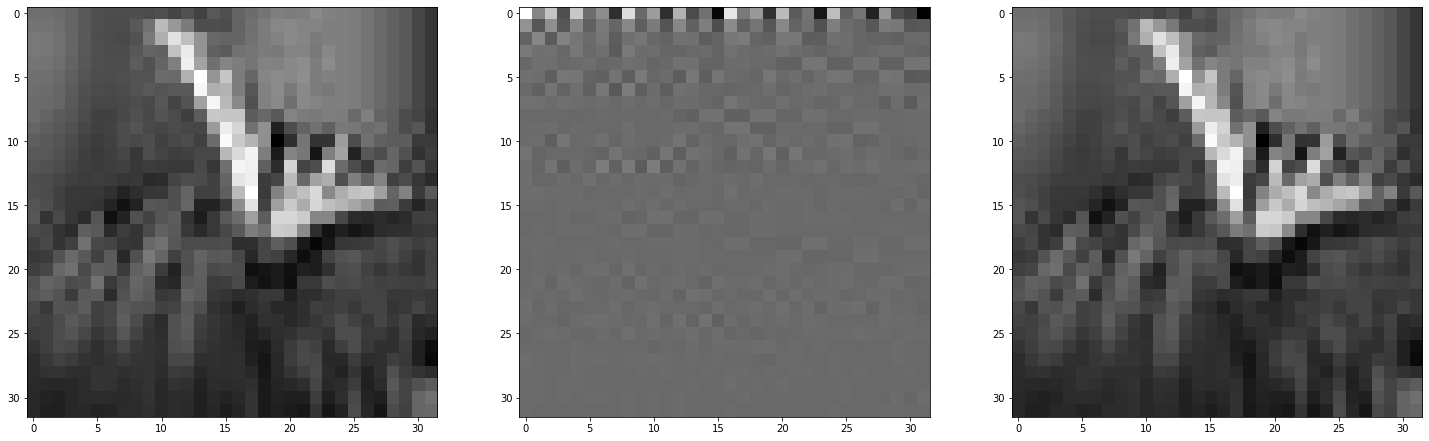

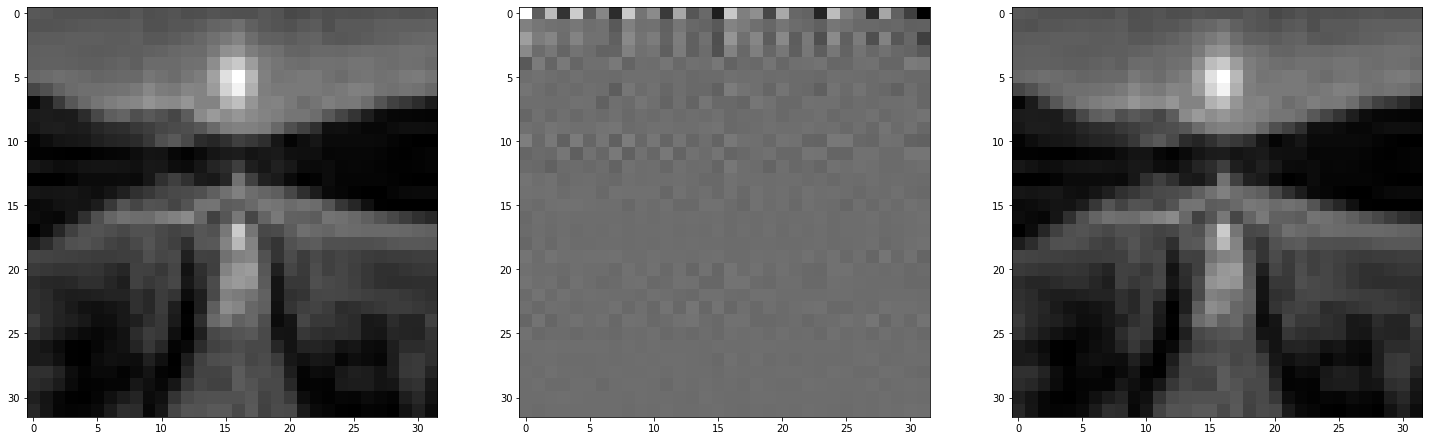

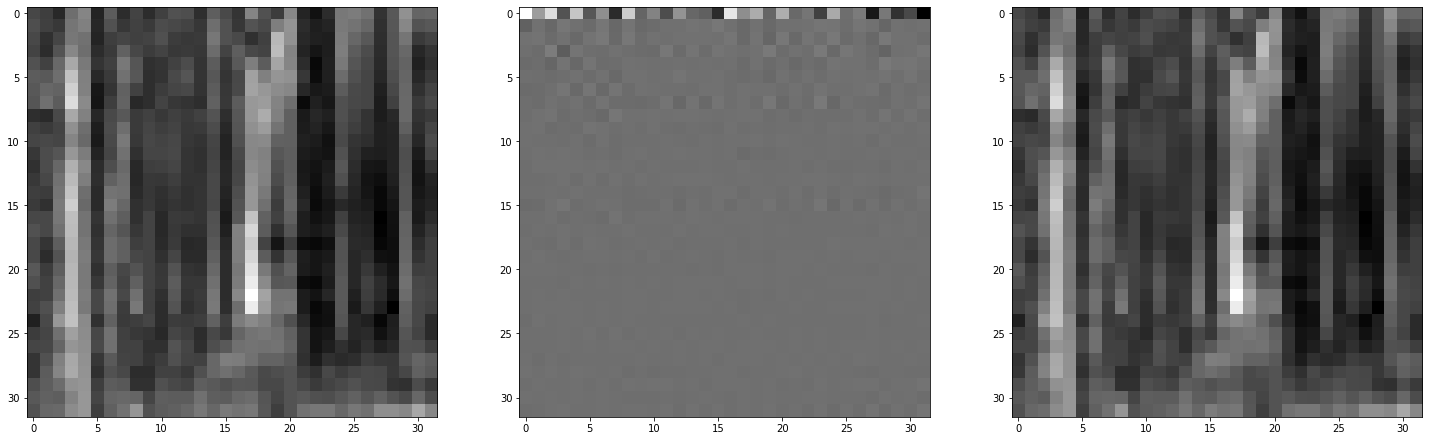

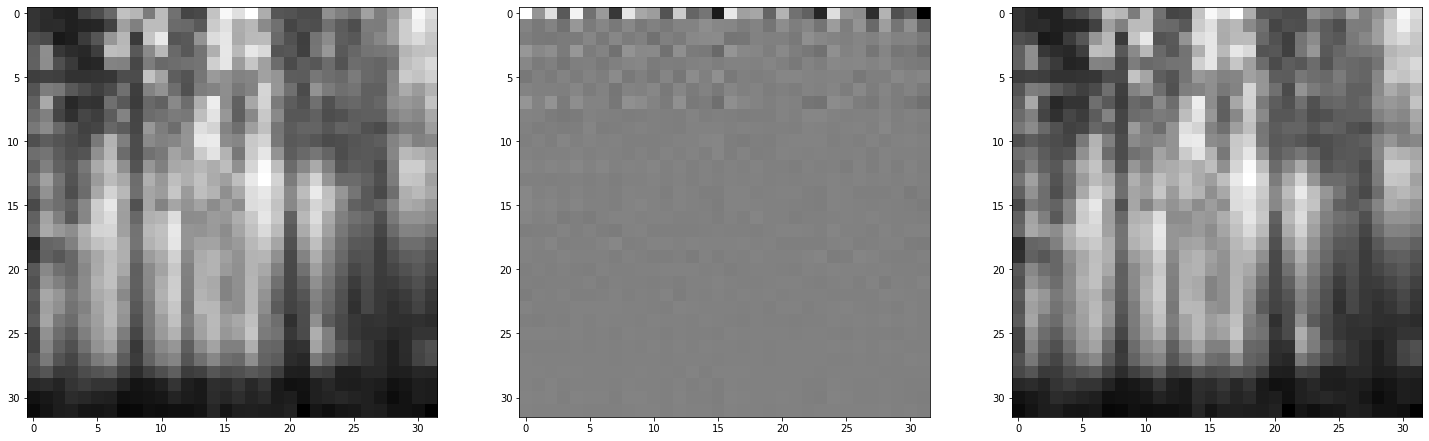

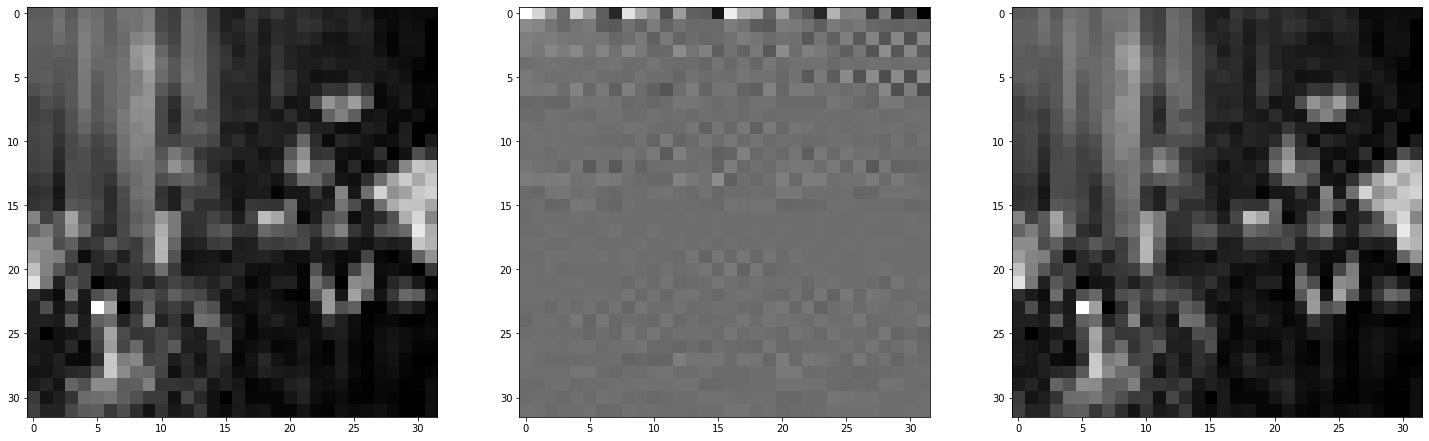

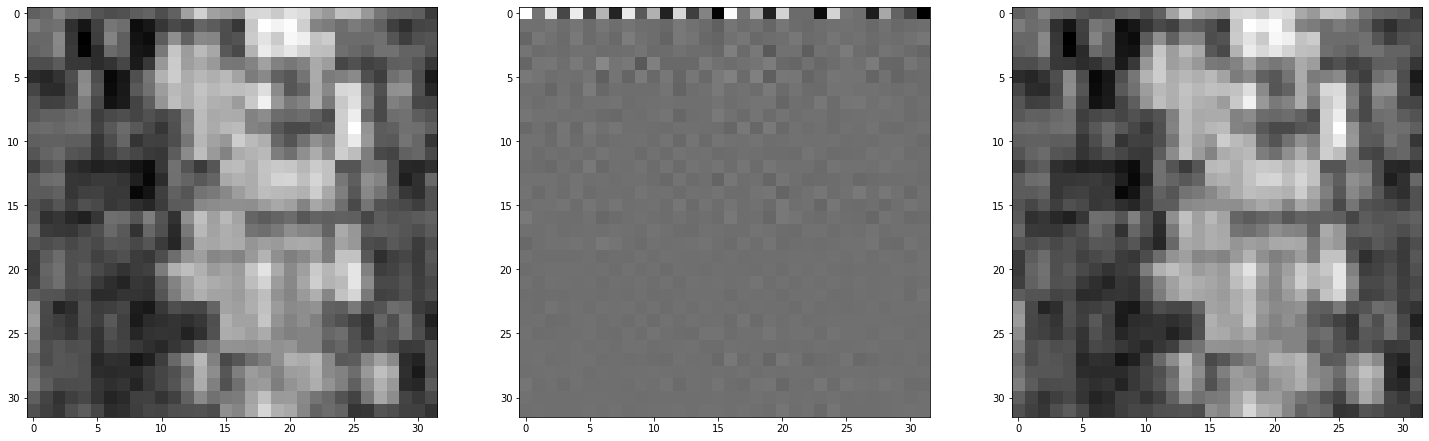

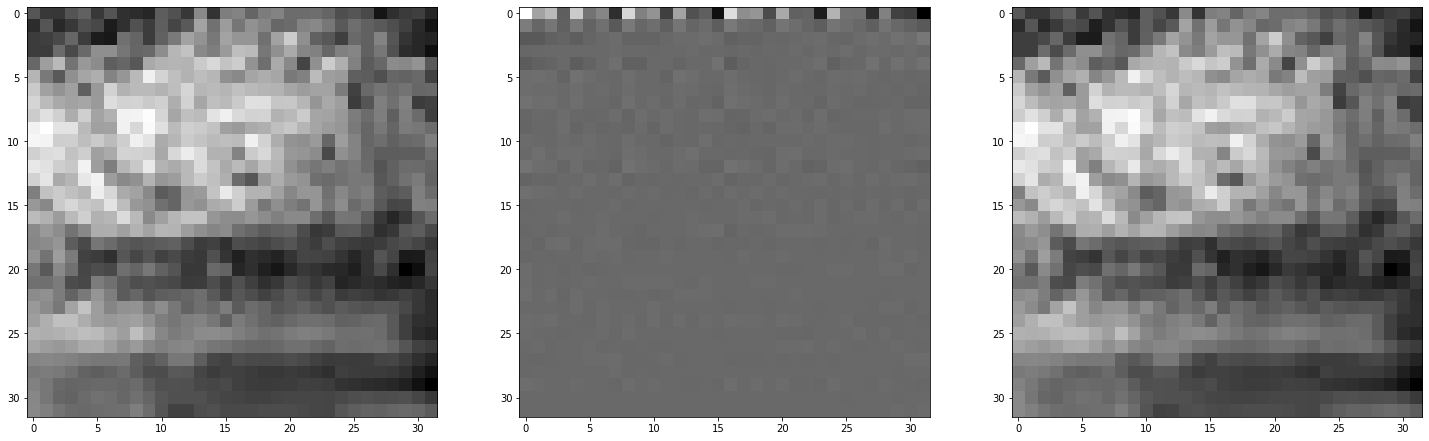

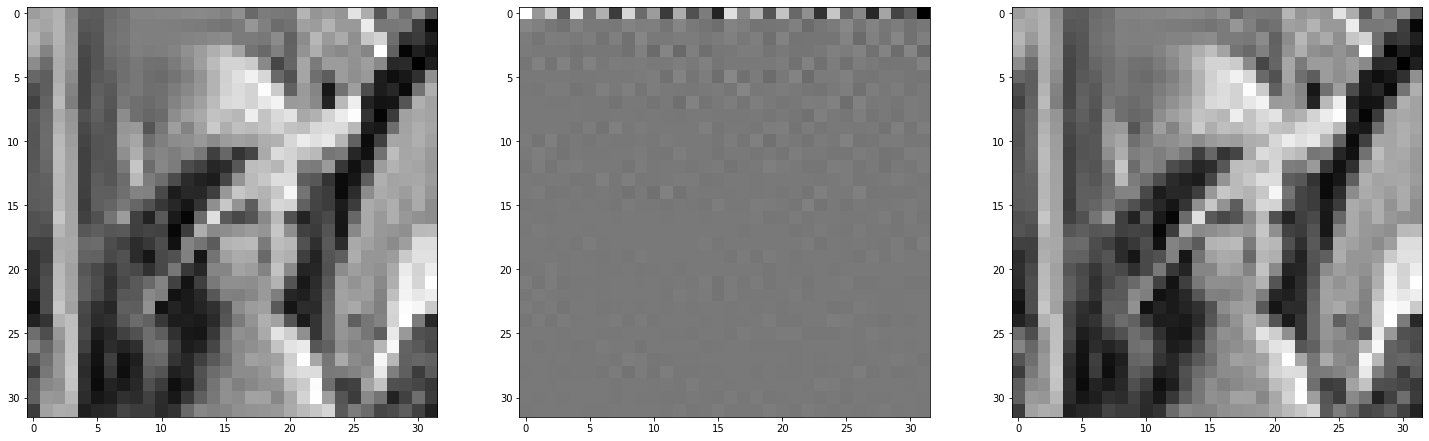

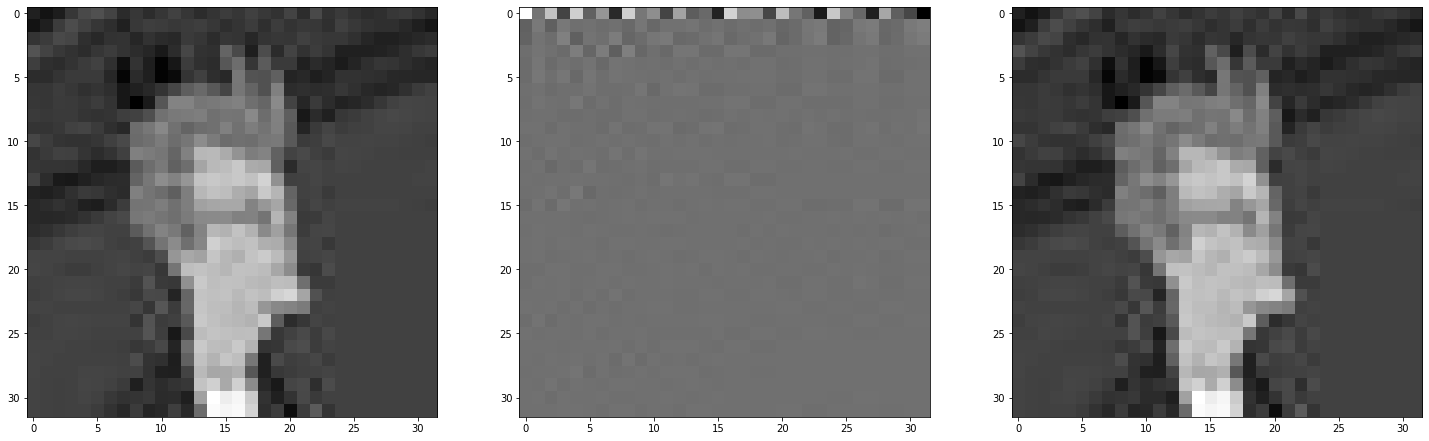

In [20]:
trans1 = []
inv_trans1 = []
for i in range(len(ima)):
    trans1.append(HaarTrans(ima[i]))
    inv_trans1.append(InvHaarTrans(trans1[i]))
    show(ima[i], trans1[i], inv_trans1[i]) # shows the original image, the Haar transform, and the inverse

In [21]:
ima = []
for filename in glob.glob('imagesHW2/32x32/*.jpg'): #assuming gif
    im = Image.open(filename)
    im = im.convert('L')
    ima.append(im)

In [22]:
def DecToBin(x,n):
    return format(x,'0'+ str(n) +'b')

In [23]:
def walsh_expx(x,u,l,n):
    x, u = DecToBin(x,n), DecToBin(u,n)
    #print("bin x:" + x)
    #print("bin u:" + u)
    #print("bin x at location: x[" + str(l) + "] " + x[l])
    #print("bin u at location: u[" + str(n-1-l)+ "] " + u[n-1-l])
    res = int(x[l]) * int(u[n-1-l])
    #print("res: " + str(res))
    
    return res 

In [24]:
def walshx(x,u,N):
    base = 1
    n = int(log(N,2))
    
    for i in range(n):
        walsh_exp = walsh_expx(x,u,i,n)
        #print(walsh_exp)
        base *= ((-1) ** walsh_exp)
        #print(base)
    #print("last:" + str(base))    
    return base

In [25]:
def create_kernel(N):
    kernel = np.zeros((N,N), dtype=float)
    for i in range(N):
        for j in range(N):
            kernel[i][j] = walshx(i,j,N)
    
    kernel /= N
    
    return kernel

In [26]:
def walshTrans(img):
    img = np.asarray(img)
    N = img.shape[0]
    kernel = create_kernel(N)
    arr = np.asarray(img)
    trans = np.matmul(kernel, img)
    trans = np.matmul(trans, kernel)
    trans = np.around(trans)
    #plt.imshow(trans, cmap="gray")
    return trans
    

In [27]:
def InvWalshTrans(trans):
    N = trans.shape[0]
    kernel = create_kernel(N)
    inv = np.linalg.inv(kernel)
    inv_trans = np.matmul(inv, trans)
    inv_trans = np.matmul(inv_trans, inv)
    inv_trans = np.around(inv_trans)
    #plt.imshow(inv_trans, cmap="gray")
    return inv_trans

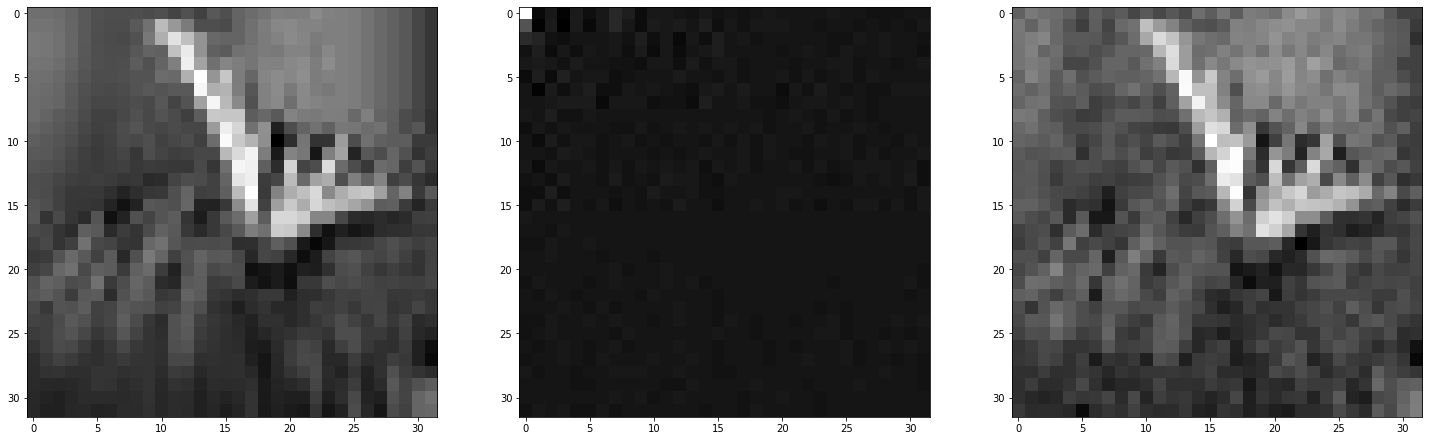

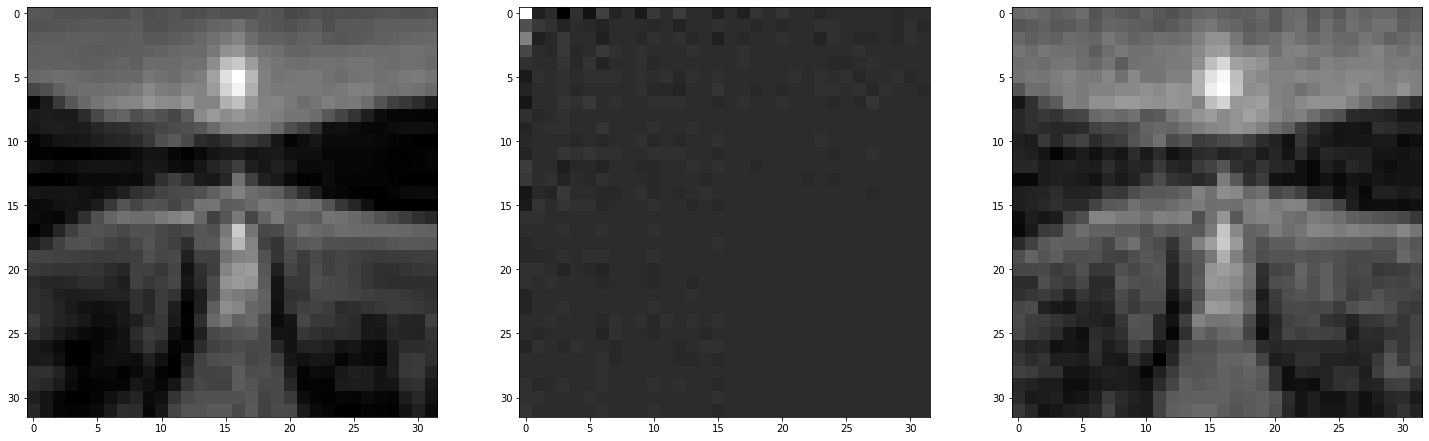

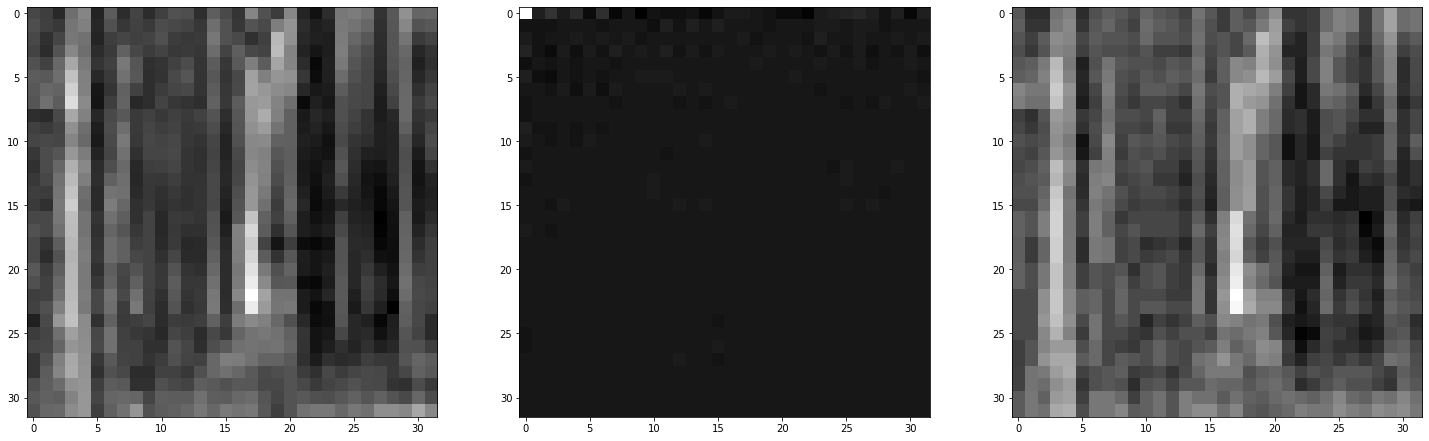

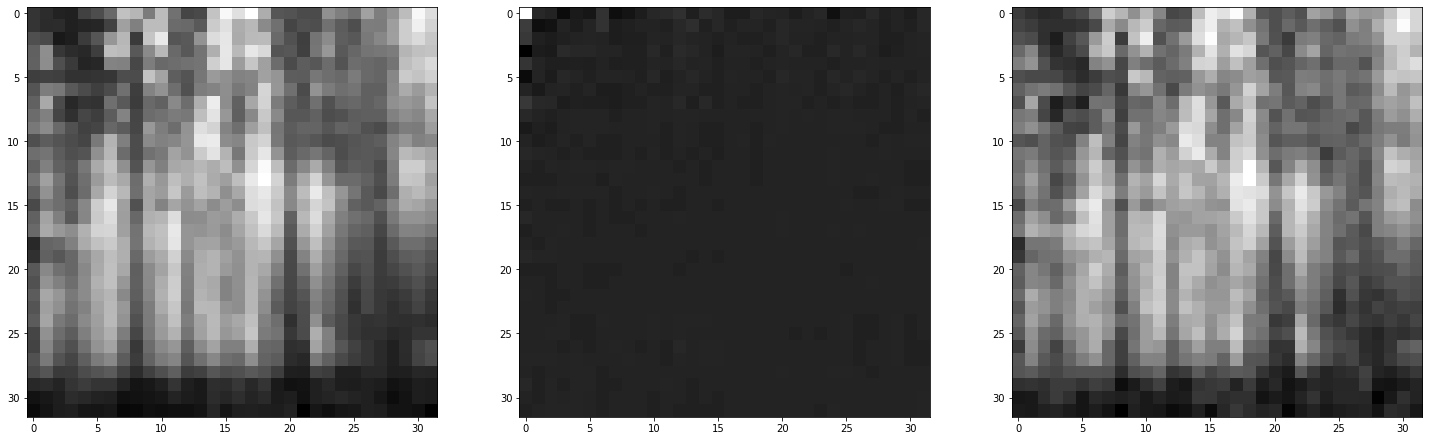

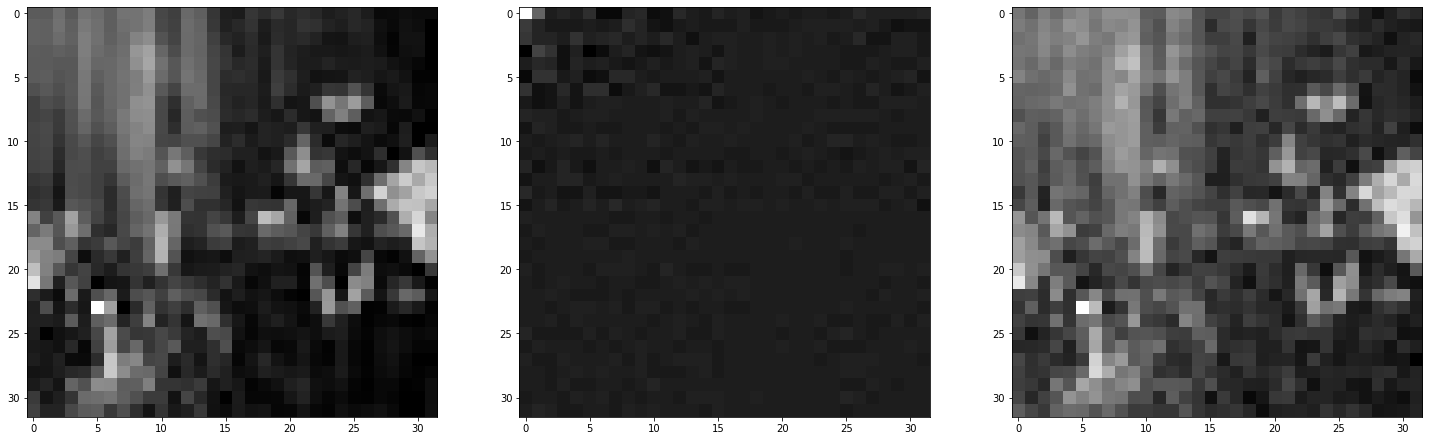

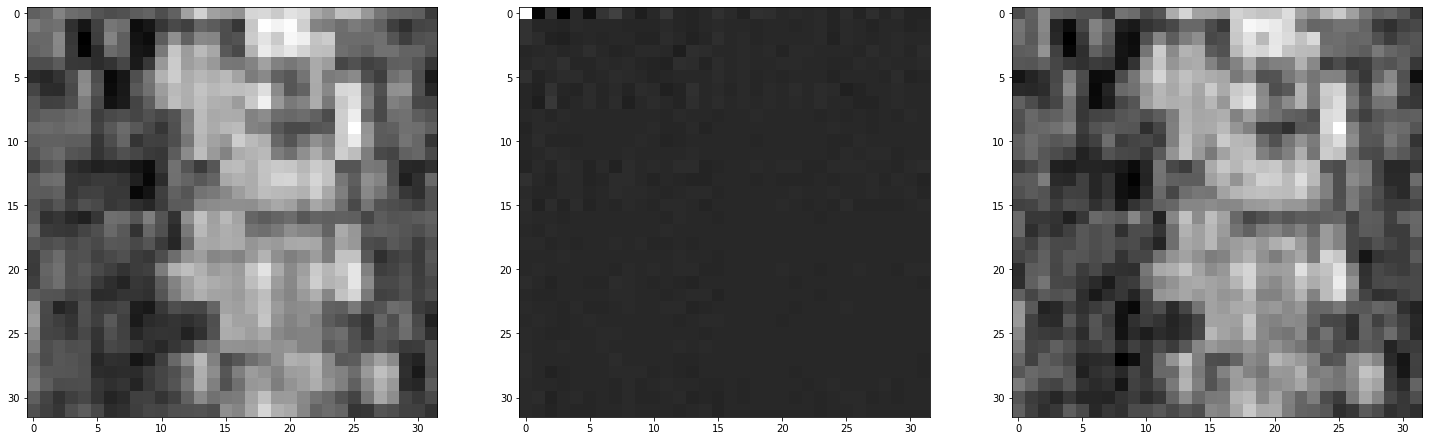

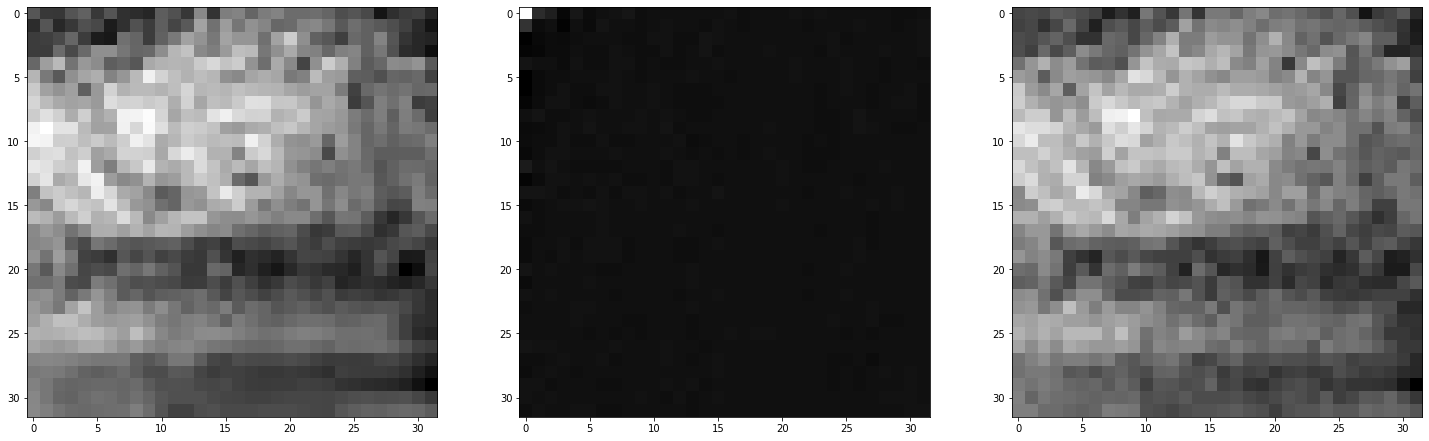

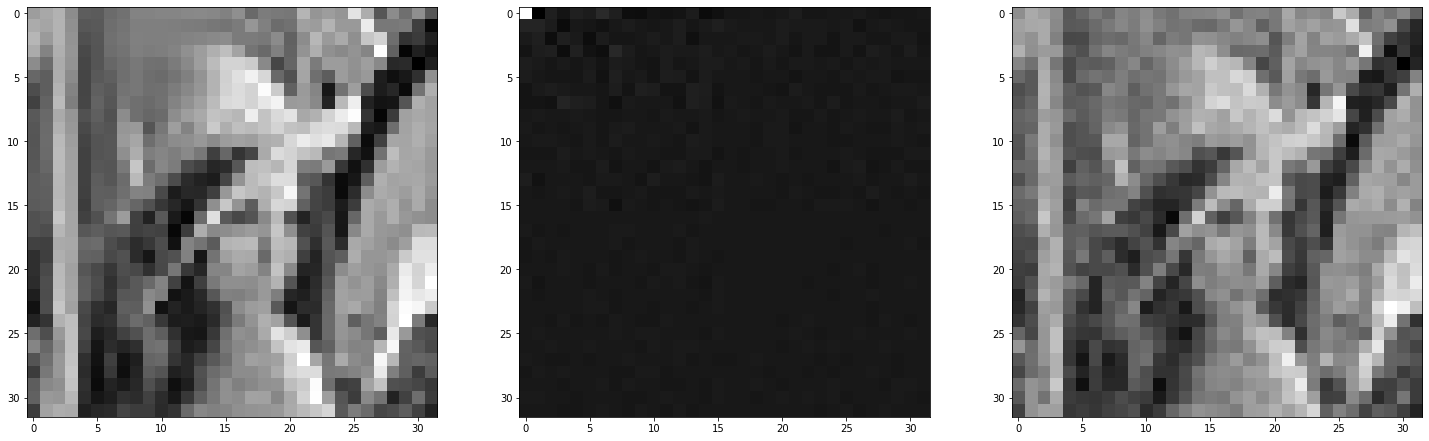

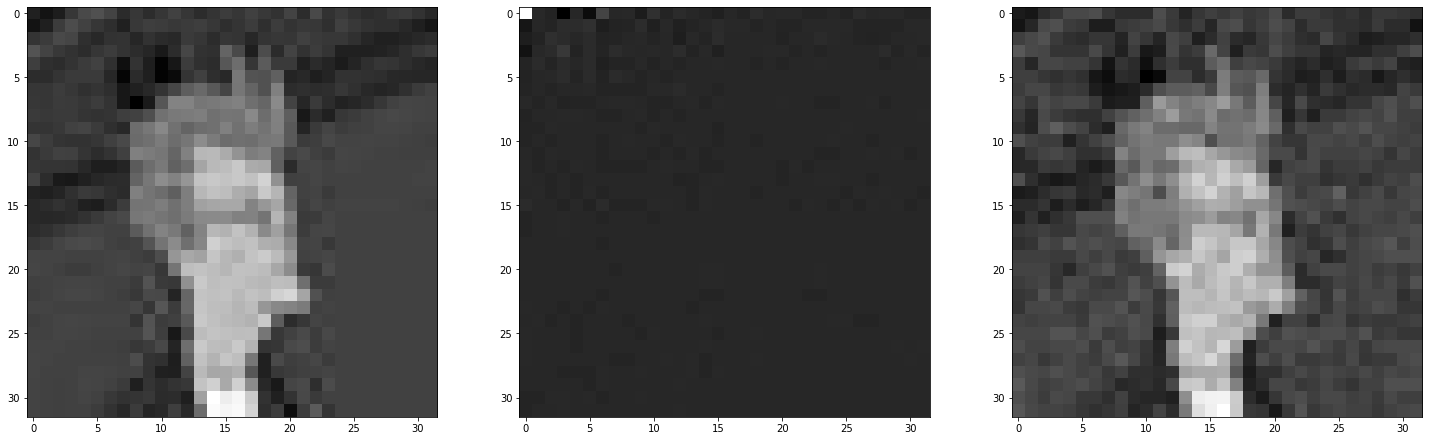

In [28]:
trans2 = []
inv_trans2 = []
for i in range(len(ima)):
    trans2.append(walshTrans(ima[i]))
    inv_trans2.append(InvWalshTrans(trans2[i]))
    show(ima[i], trans2[i], inv_trans2[i])

# Result:
Here are all the transform, DCT, Harr, Walsh.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


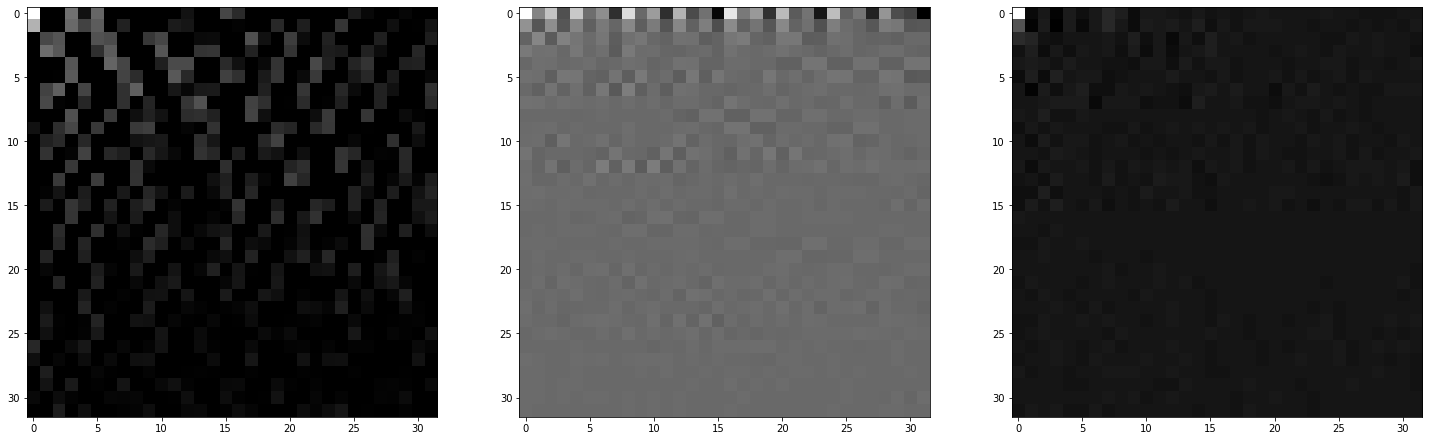

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


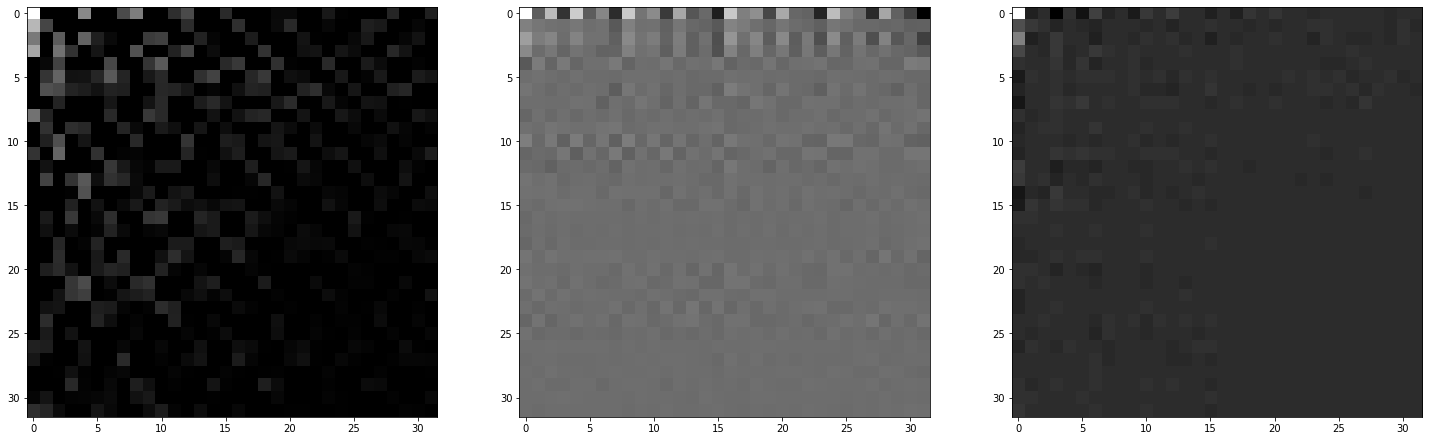

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


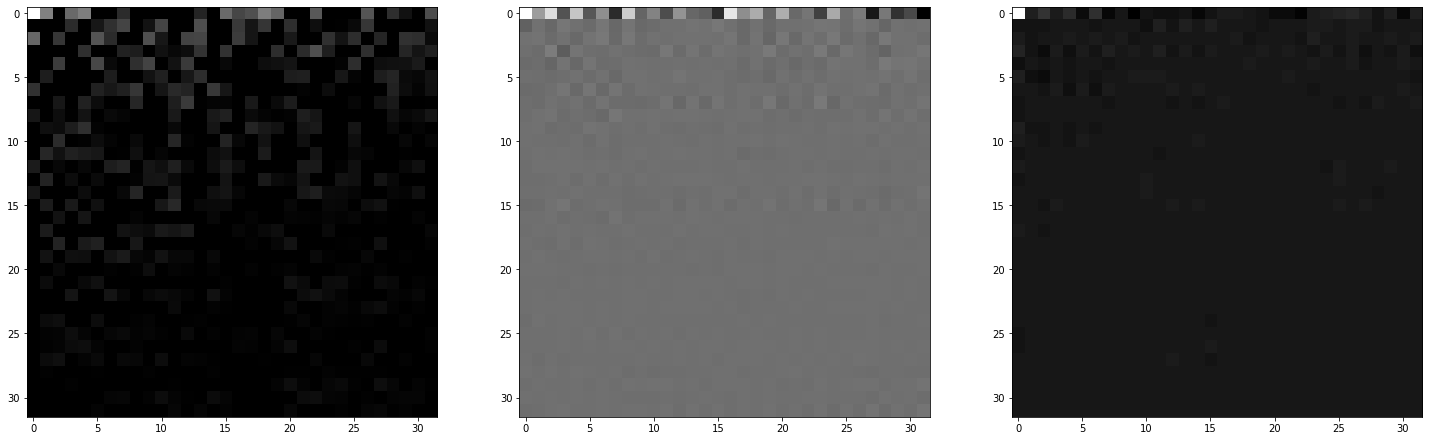

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


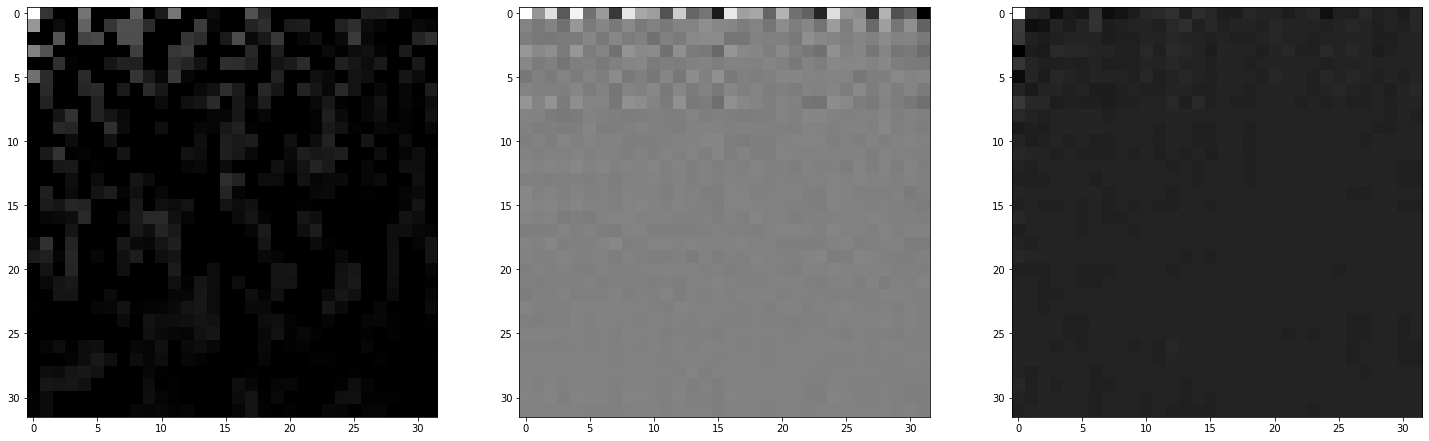

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


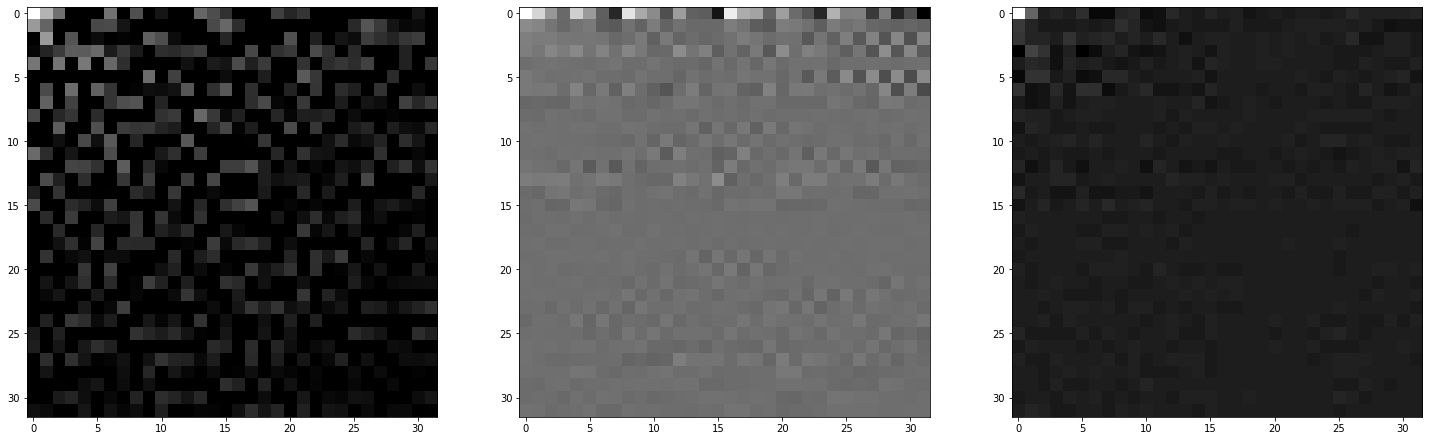

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


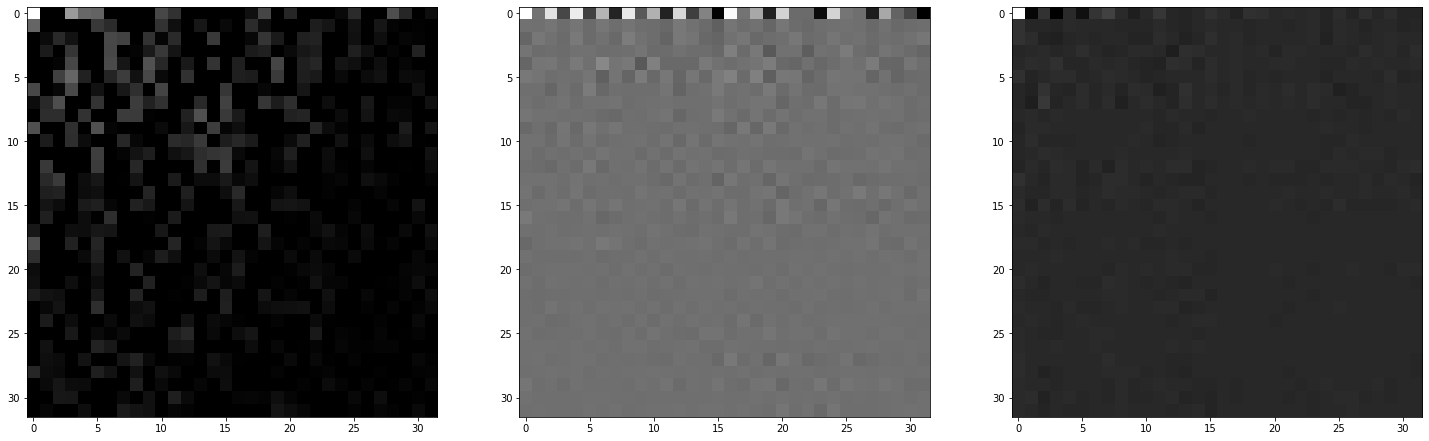

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


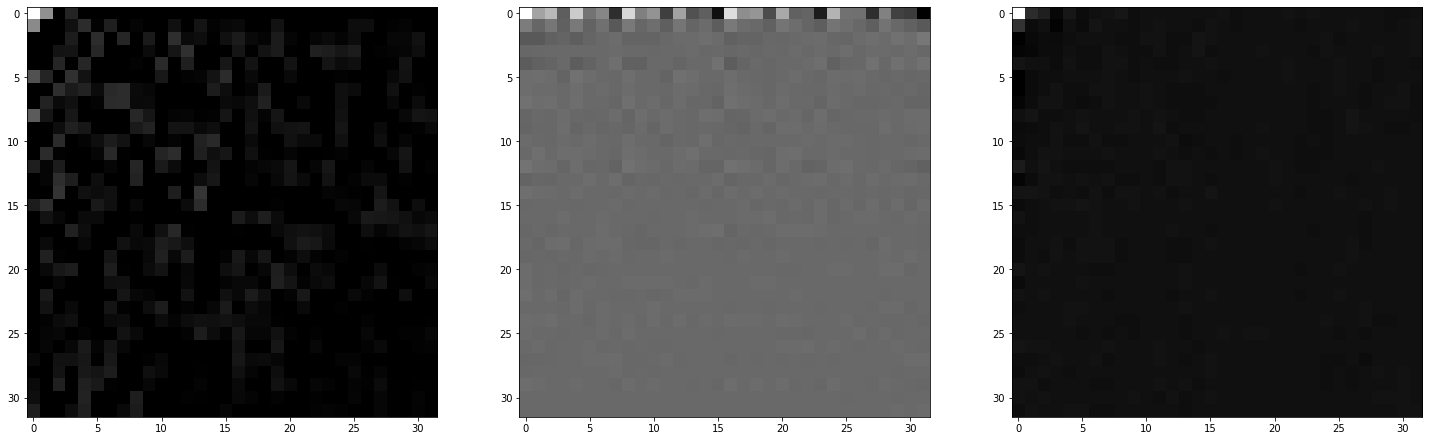

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


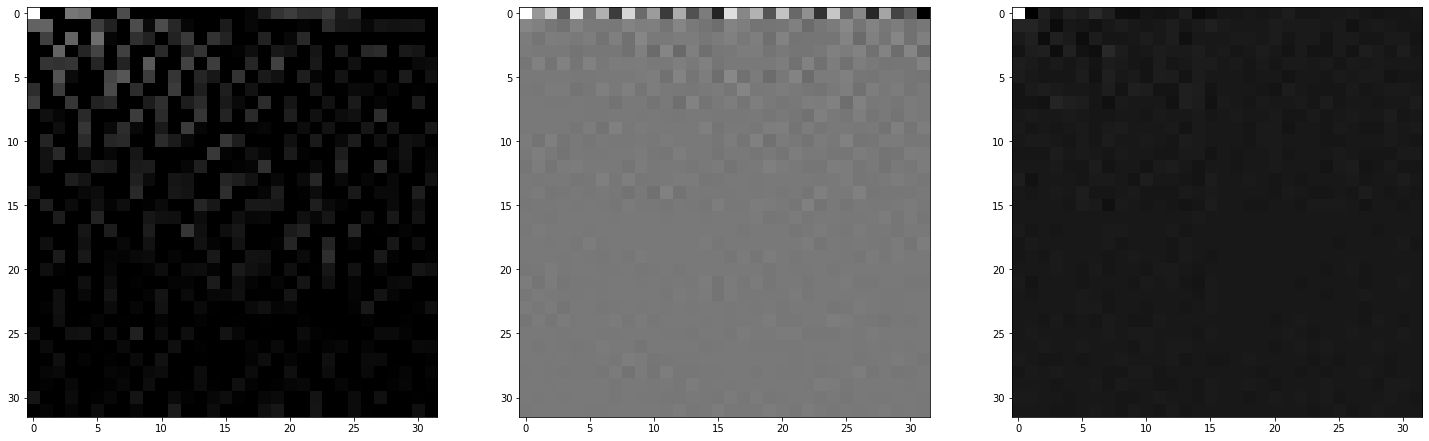

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


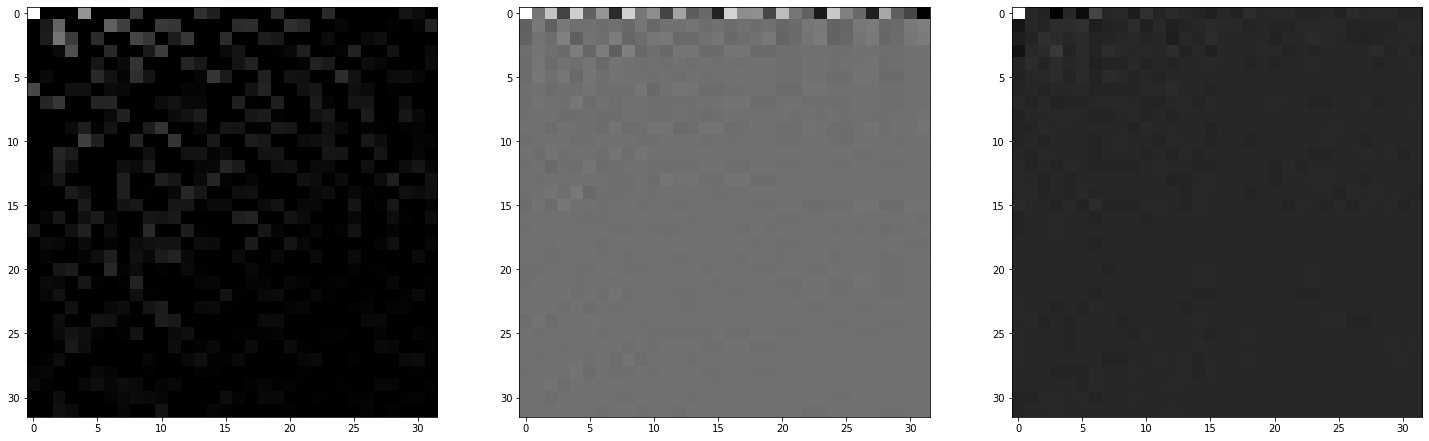

In [30]:
for i in range(len(ima)):
    show(trans[i], trans1[i], trans2[i]) #DCT, Haar,Walsh

# Conclusion
We can clearly see that the DCT compacts more signals in the top left, the Haar compacts more energy on towars the top, and the Walsh is almost like the DCT but signals are average out more though graph.